In [1]:
from dataset import create_dataset, create_sampler, create_loader
import argparse
import ruamel.yaml as yaml
import torch
import numpy as np
from matplotlib import pyplot as plt
import json
import os 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("./workspace/")
os.getcwd()

'/workspace'

In [3]:
def img_show(img):
    img = torch.permute(img,dims=(1,2,0)).detach().numpy()
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.axis(False)
    plt.show()
    
def img_show_2(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.axis(False)
    plt.show()


In [4]:
parser = argparse.ArgumentParser()     
parser.add_argument('--config', default='./configs/Retrieval_coco_romix.yaml')
parser.add_argument('--output_dir', default='output/Retrieval_full_romix_wj')        
parser.add_argument('--checkpoint', default='')   
parser.add_argument('--text_encoder', default='bert-base-uncased')
parser.add_argument('--evaluate', action='store_true')
parser.add_argument('--device', default='cuda')
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--world_size', default=1, type=int, help='number of distributed processes')    
parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
parser.add_argument('--distributed', default=True, type=bool)
args = parser.parse_args([])

config = yaml.load(open(args.config, 'r'), Loader=yaml.Loader)
config['output_dir'] = args.output_dir

In [5]:
train_dataset, val_dataset, test_dataset = create_dataset('re', config)  

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [6]:
len(train_dataset.romixgen.obj_bg_dict["obj"]), len(train_dataset.romixgen.obj_bg_dict["bg"]), len(train_dataset.romixgen.obj_bg_dict["unusable_bg"])

(118248, 2961, 2078)

In [7]:
import pandas as pd
img_info = pd.DataFrame(train_dataset.romixgen.image_info_dict).transpose()

In [8]:
mop_og = img_info["max_obj_area_portion"].copy()
mop_ch = img_info["mop"].copy()

In [9]:
len(img_info[img_info["mop"]==1])

459

In [10]:
mop_og.sort_values(inplace=True)
mop_og.reset_index(drop=True, inplace=True)
mop_ch.sort_values(inplace=True)
mop_ch.reset_index(drop=True, inplace=True)

In [11]:
def center_check(midpoint: list, width: int, height: int, thrs: float):
    width_area = [0 + width * ((1 - thrs) / 2), width - width * ((1 - thrs) / 2)]
    height_area = [
        0 + height * ((1 - thrs) / 2),
        height - height * ((1 - thrs) / 2),
    ]
    try:
        if midpoint[0] > width_area[0] and midpoint[0] < width_area[1]:
            if midpoint[1] > height_area[0] and midpoint[1] < height_area[1]:
                return True
            else:
                return False
        else:
            return False
    except:
        return False

def romixgen_preset( img_info_dict, obj_bg_threshold=0.01, bg_center_threshold=0.7 ):
    seg_or_bbox = "bbox"
    for key in img_info_dict.keys():
        try:
            max_obj_area_portion = img_info_dict[key]["max_obj_area_portion"]
            max_obj_midpoint = img_info_dict[key]["max_obj_midpoint"]
            img_width, img_height = int(img_info_dict[key]["width"]), int(img_info_dict[key]["height"])
            """try:
                max_obj_area_portion = (img_info_dict[key]["max_obj_bbox"][2] * img_info_dict[key]["max_obj_bbox"][3])/(img_width * img_height)
            except:
                max_obj_area_portion = None"""
            img_info_dict[key]["mop"] = max_obj_area_portion
            if max_obj_area_portion:
                img_info_dict[key].pop( "max_obj_segment_points", None ) if seg_or_bbox == "bbox" else img_info_dict[key].pop("max_obj_bbox", None)
                if ( max_obj_area_portion > obj_bg_threshold):  # 물체가 이미지의 일정 비율 이상 차지하는 경우
                    img_info_dict[key]["obj_bg"] = "obj"
                else:
                    if center_check( max_obj_midpoint, img_width, img_height, bg_center_threshold):  # 빈 곳의 중심이 이미지의 중심에 가까운 경우
                        img_info_dict[key]["obj_bg"] = "bg"
                    else:  # 빈 곳의 중심이 이미지의 중심에 가깝지 않은 경우 (외곽에 위치한 경우)
                        img_info_dict[key]["obj_bg"] = "unusable_bg"
            else:  # max obj 비어있는 경우 (그냥 unusable bg로 저장)
                img_info_dict[key]["obj_bg"] = "unusable_bg"
        except Exception as e:
            print(f"Error processing image {img_info_dict[key]['file_name']}: {e}")
    obj_bg_dict = {}

    # obj,bg key를 가진 dictionary 생성
    for key in img_info_dict.keys():
        if img_info_dict[key]["obj_bg"] not in obj_bg_dict:
            obj_bg_dict[img_info_dict[key]["obj_bg"]] = [key]
        else:
            obj_bg_dict[img_info_dict[key]["obj_bg"]].append(key)

    return img_info_dict, obj_bg_dict

In [12]:
img_info_dict = json.load(open(config['img_info_json'], 'r'))

In [13]:
img_info_dict_fixed, obj_bg_dict = romixgen_preset(img_info_dict, obj_bg_threshold=0.01, bg_center_threshold=0.7)

In [14]:
len(obj_bg_dict["obj"]), len(obj_bg_dict["bg"]), len(obj_bg_dict["unusable_bg"])

(115053, 5521, 2713)

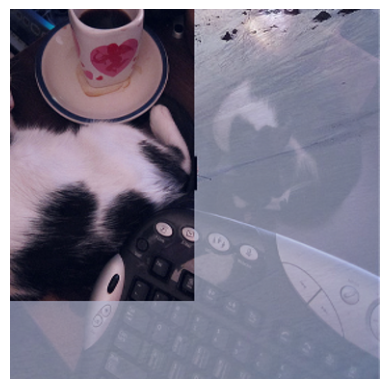

Cats are floating in the water near the shore.


In [19]:
img_show(train_dataset[1290][0])
print(train_dataset[1290][1])

In [17]:
train_dataset[1800][1]

'A body of water with several people on bears.'

In [12]:
img_info = json.load(open(config['img_info_json'], 'r'))

In [18]:
import cv2
import numpy as np
from torchvision import transforms

from augmentation.romixgen import MiX, RoMixGen_Img, RoMixGen_Txt
from dataset.randaugment import RandomAugment
from PIL import Image

In [46]:
transform_after_mix      = transforms.Compose([
                                            transforms.RandomResizedCrop(config['image_res'],scale=(0.5, 1.0), interpolation=Image.BICUBIC),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
                                        ])

rmx_img = RoMixGen_Img( image_root            = config['image_root'],
                        transform_after_mix   = transform_after_mix,
                        resize_ratio          = config['romixgen_resize_ratio'],
                        img_mix               = config['romixgen_img_mix'],
                        obj_bg_mix_ratio      = config['obj_bg_mix_ratio'],)
rmx_txt = RoMixGen_Txt()
rmx_img.__get_dict__(train_dataset.romixgen.use_sub_dict_key(train_dataset.romixgen.image_info_dict,["file_name", "max_obj_midpoint", "max_obj_bbox"], ))
rmx_txt.__get_dict__(train_dataset.romixgen.use_sub_dict_key(train_dataset.romixgen.image_info_dict,["file_name", "max_obj_super_cat", "max_obj_cat", "captions"], ))

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [47]:
def img_show_2(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

def bbox_point(bboxes):
    y_up = int(bboxes[1])
    y_down = y_up + int(bboxes[3])
    x_left = int(bboxes[0])
    x_right = x_left + int(bboxes[2])
    return x_left,x_right,y_up,y_down

def __cut_obj__(bboxes, img, obj_bg: str):
    x_left,x_right,y_up,y_down = bbox_point(bboxes)
    if obj_bg == "obj":
        result = np.array(img)[y_up:y_down,x_left:x_right,:]
    # if obj_bg is bg return out area of image
    elif obj_bg == "bg":
        result = np.array(img)
        result[y_up:y_down,x_left:x_right,:] = 0
    return result 

def __paste_obj__(bboxes, bg_img, obj_img):
    x_left, x_right, y_up, y_down = bbox_point(bboxes)
    bg_img[y_up:y_down, x_left:x_right, :] = obj_img
    return bg_img

def __resize__(obj_img, bg_img, size, bbox):
    # img resize
    width_ratio, height_ratio = size[0] / obj_img.shape[1], size[1] / obj_img.shape[0]
    obj_img = cv2.resize(obj_img, size, interpolation=cv2.INTER_CUBIC)
    bg_img = cv2.resize(bg_img, size, interpolation=cv2.INTER_CUBIC)
    bbox = [bbox[0] * width_ratio, bbox[1] * height_ratio, bbox[2] * width_ratio, bbox[3] * height_ratio]
    return obj_img, bg_img, bbox

In [48]:
temp_obj_id , temp_bg_id = train_dataset.romixgen.obj_bg_dict["obj"][50], train_dataset.romixgen.obj_bg_dict["bg"][120]
print("obj_id: ", temp_obj_id, "bg_id: ", temp_bg_id)

obj_id:  179620 bg_id:  149602


In [49]:
temp_obj_filename = train_dataset.romixgen.image_info_dict[temp_obj_id]["file_name"]
temp_obj_bbox = train_dataset.romixgen.image_info_dict[temp_obj_id]["max_obj_bbox"]

temp_bg_filename = train_dataset.romixgen.image_info_dict[temp_bg_id]["file_name"]
temp_bg_bbox = train_dataset.romixgen.image_info_dict[temp_bg_id]["max_obj_bbox"]

In [50]:
#COLOR_BGR2RGB
temp_obj_img = cv2.imread(os.path.join(train_dataset.romixgen.img_aug.image_root,temp_obj_filename), cv2.IMREAD_COLOR)
temp_obj_img = cv2.cvtColor(temp_obj_img, cv2.COLOR_BGR2RGB)
temp_bg_img = cv2.imread(os.path.join(train_dataset.romixgen.img_aug.image_root,temp_bg_filename), cv2.IMREAD_COLOR)
temp_bg_img = cv2.cvtColor(temp_bg_img, cv2.COLOR_BGR2RGB)
temp_bg_img = __cut_obj__(temp_bg_bbox, temp_bg_img, "bg")

In [51]:
temp_obj_img_rs, temp_bg_img_rs, temp_obj_bbox_rs = __resize__(temp_obj_img, temp_bg_img, size=(384,384), bbox=temp_obj_bbox)

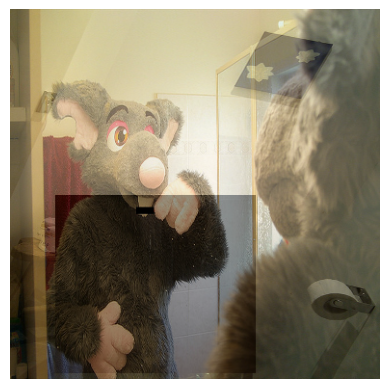

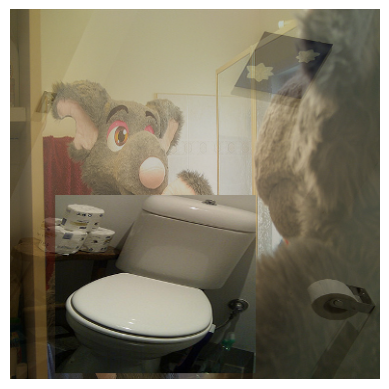

toilets A large gray rat standing in front of a bathroom mirror.


In [52]:
temp_obj_img_obj = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "obj")
temp_obj_img_bg = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "bg")

img = 0.5 * temp_obj_img_bg + 0.5 * temp_bg_img_rs
img_show_2(img)
img = __paste_obj__(temp_obj_bbox_rs, img, temp_obj_img_obj)
img_show_2(img)
print(rmx_txt(temp_obj_id, temp_bg_id))

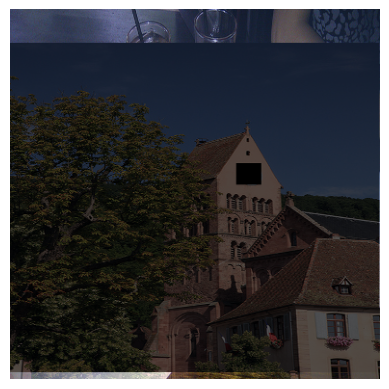

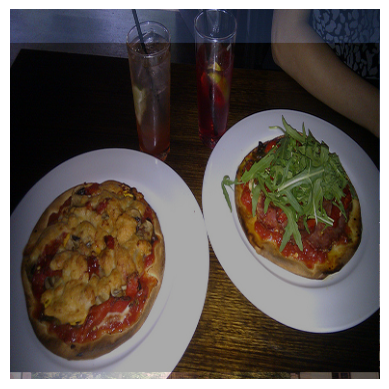

In [39]:
temp_obj_img_obj = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "obj")
temp_obj_img_bg = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "bg")

img = temp_obj_img_bg + 0.5 * temp_bg_img_rs
img_show_2(img)
img = __paste_obj__(temp_obj_bbox_rs, img, temp_obj_img_obj)
img_show_2(img)
